In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install sklearn.preprocessing

In [5]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


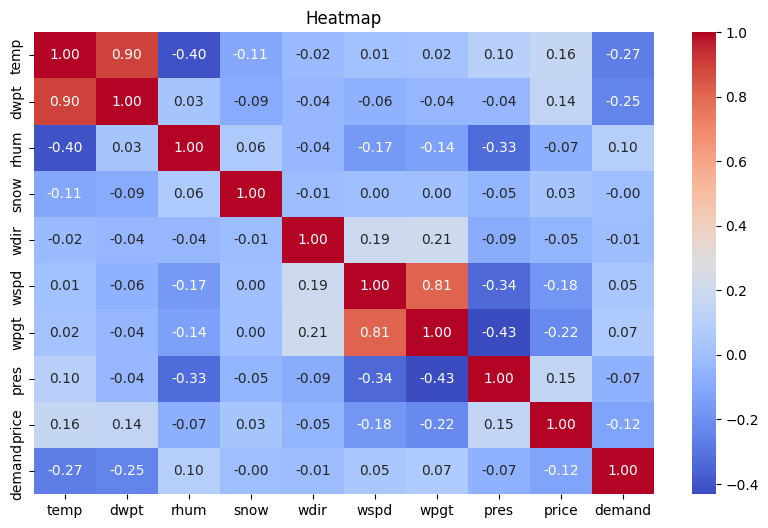

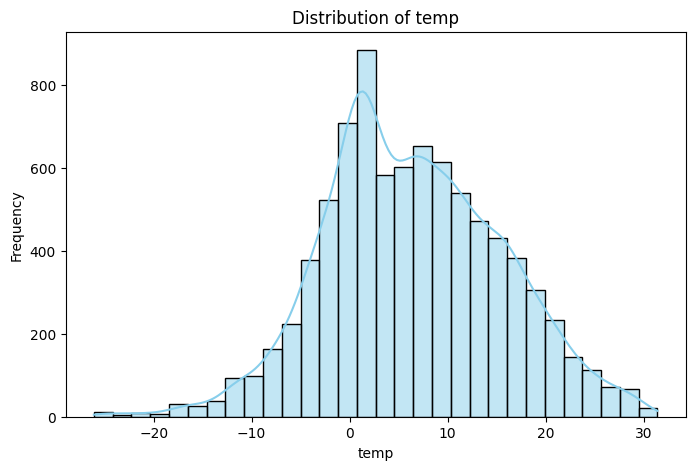

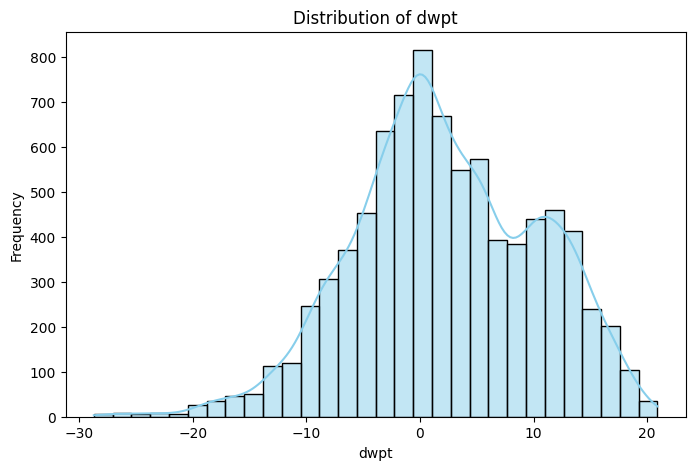

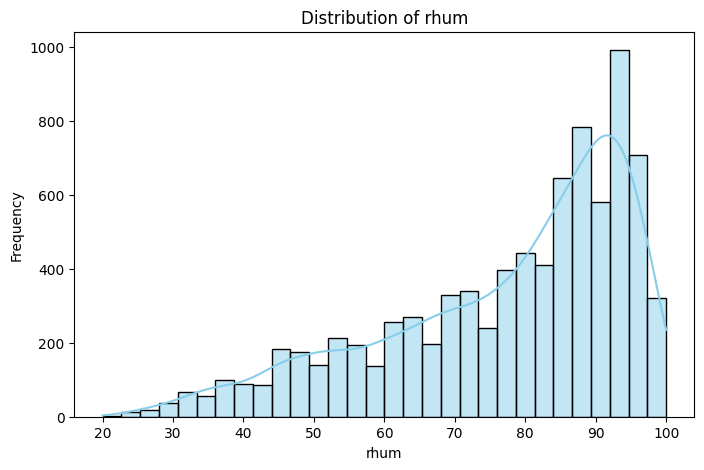

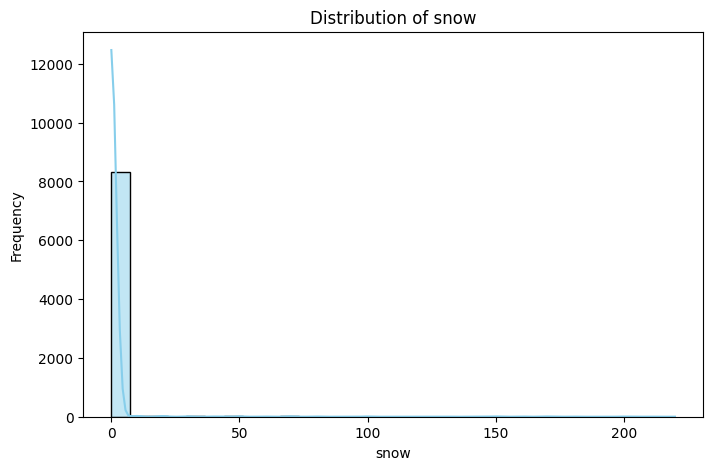

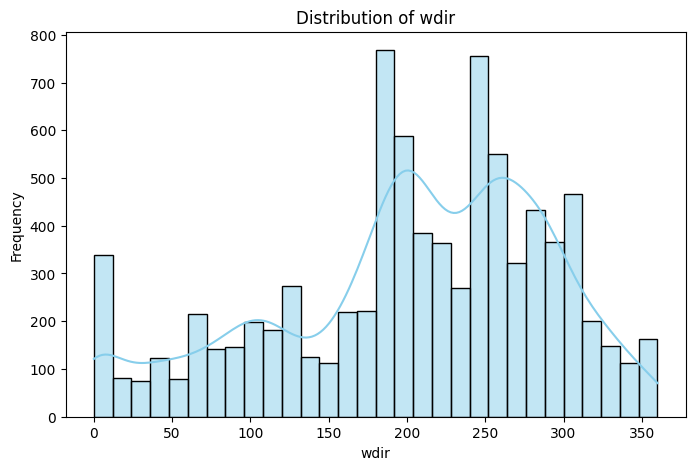

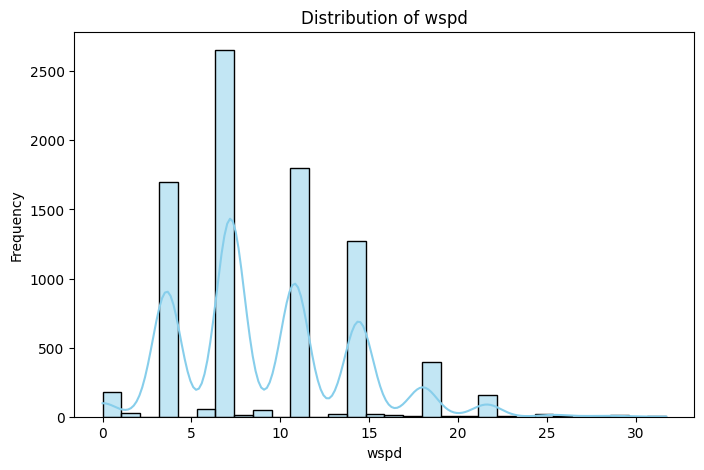

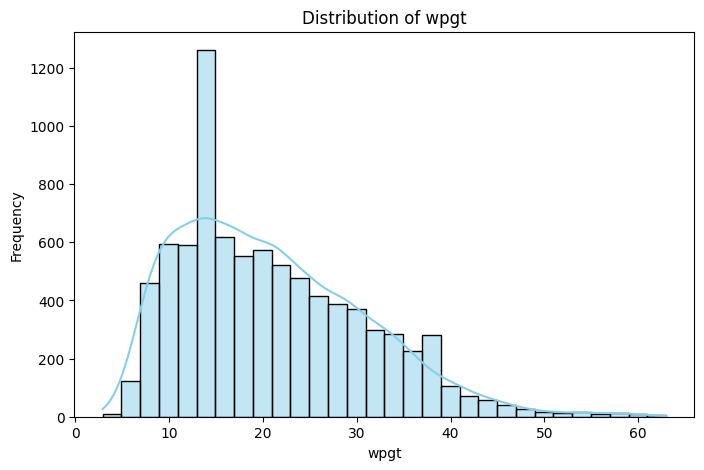

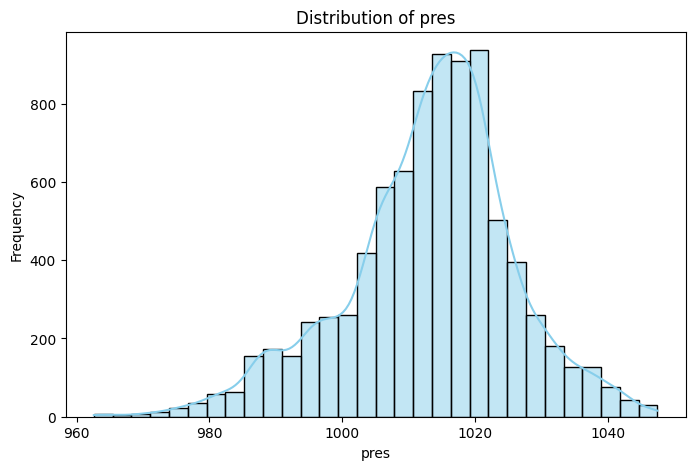

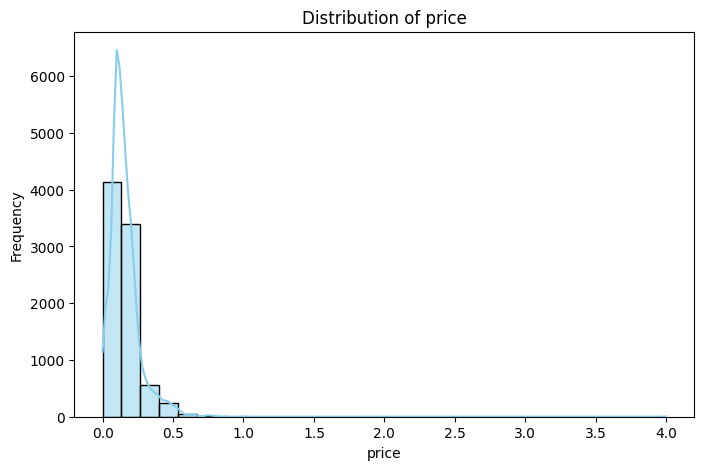

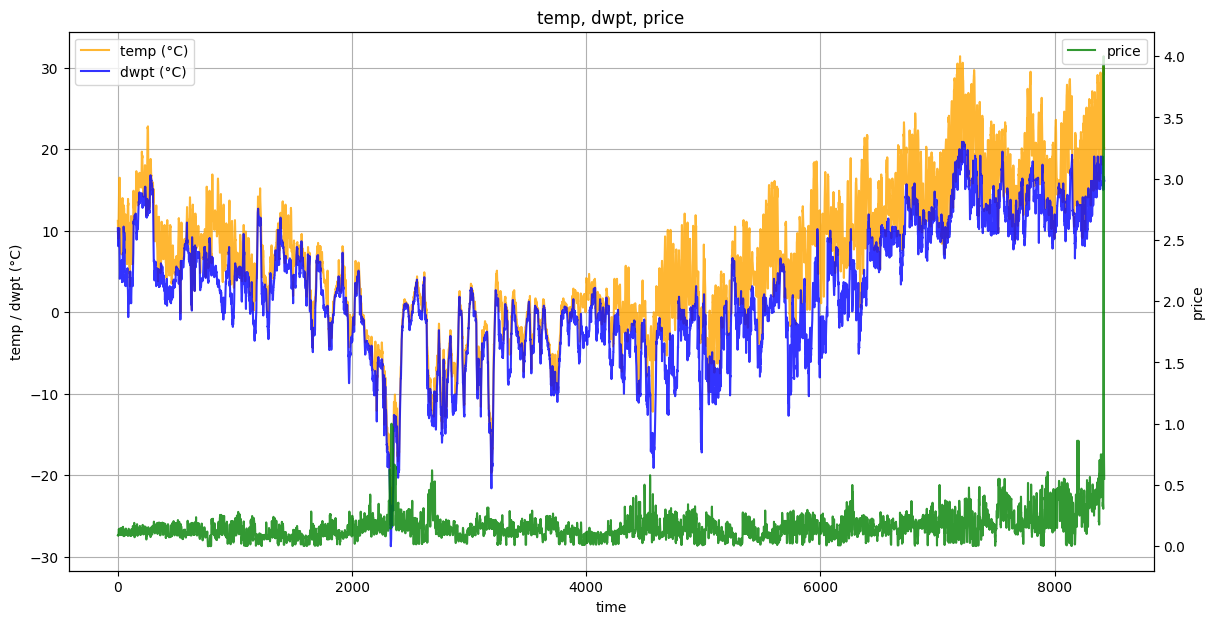

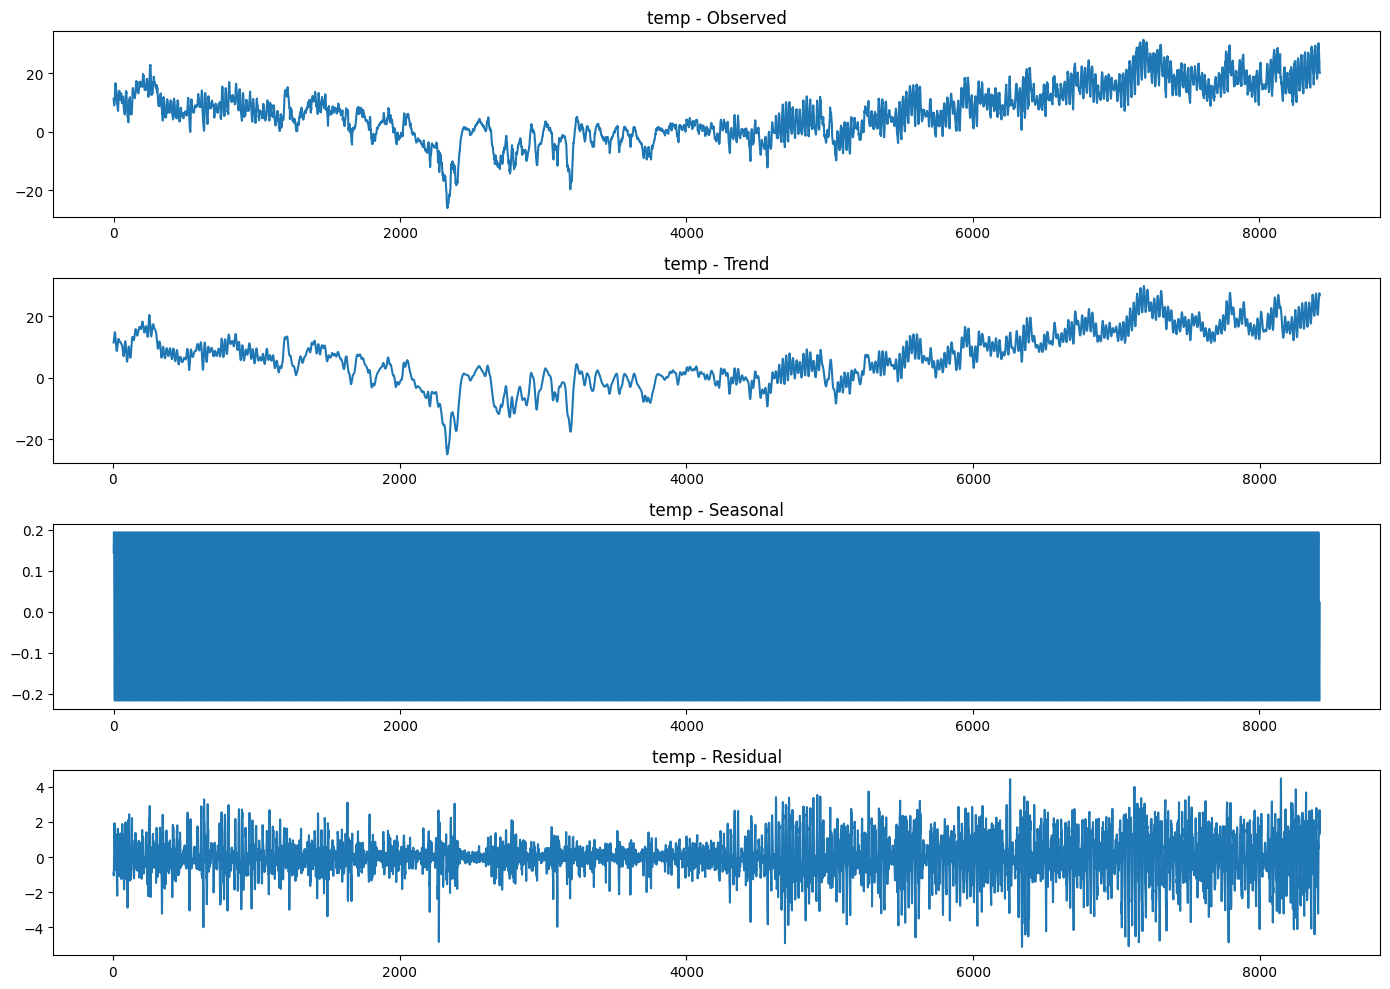

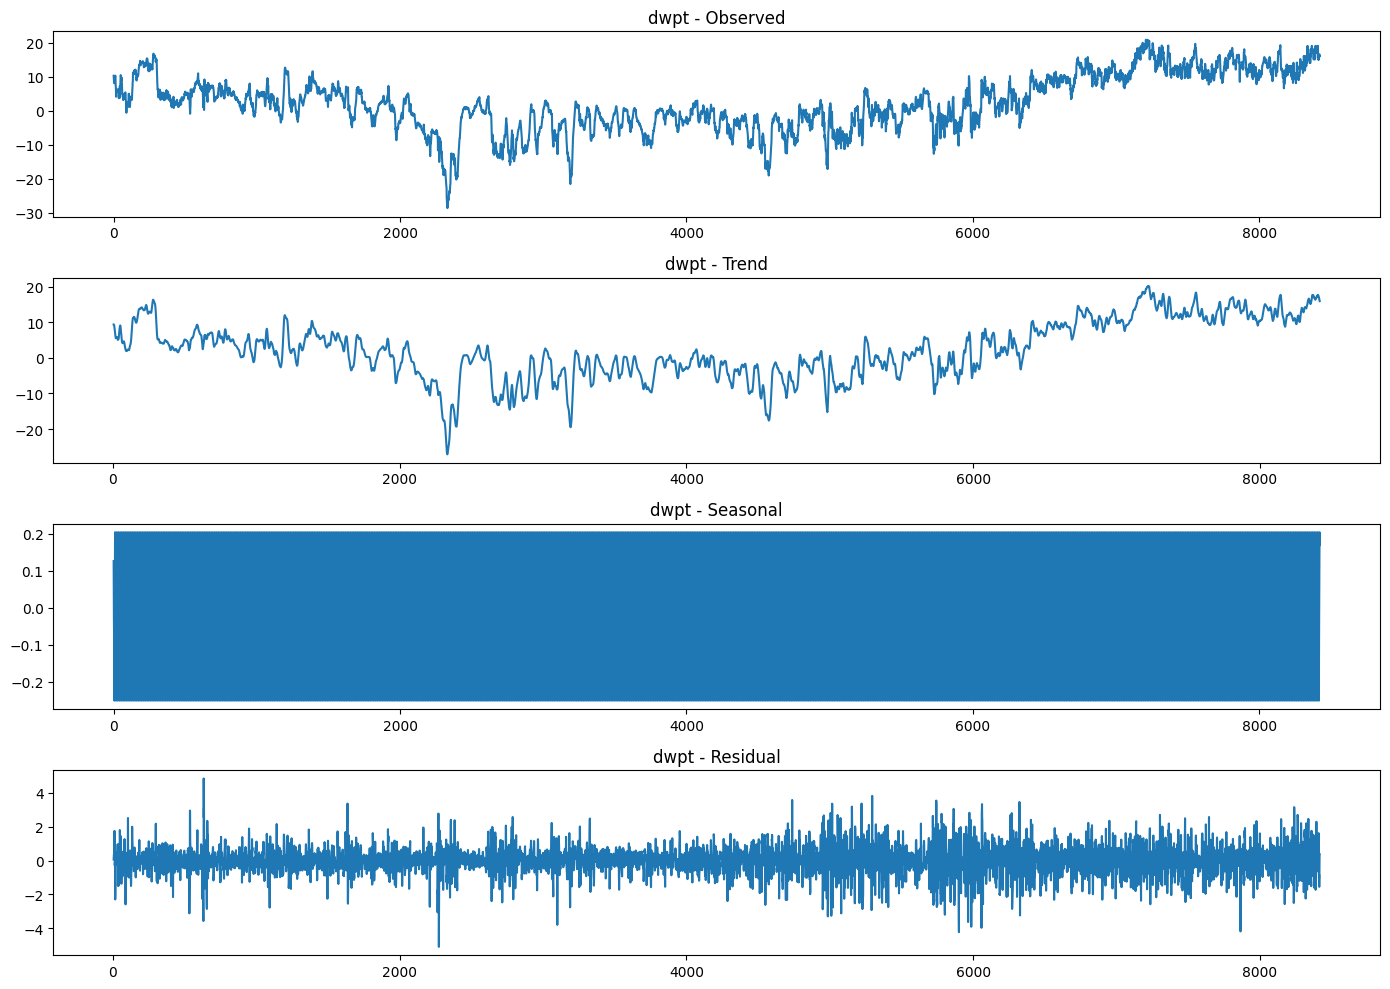

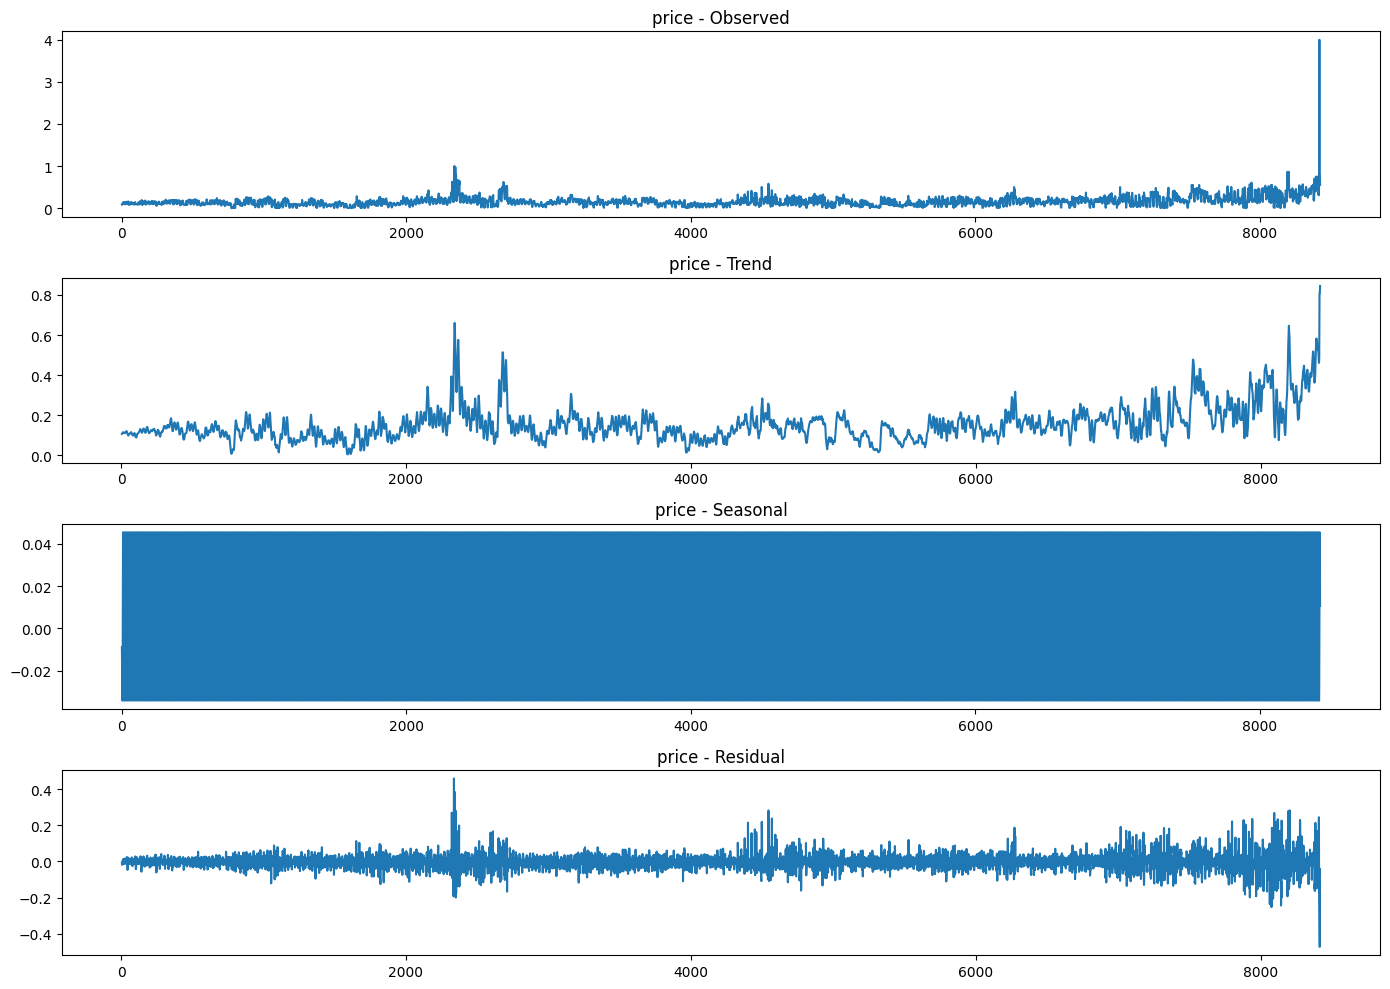

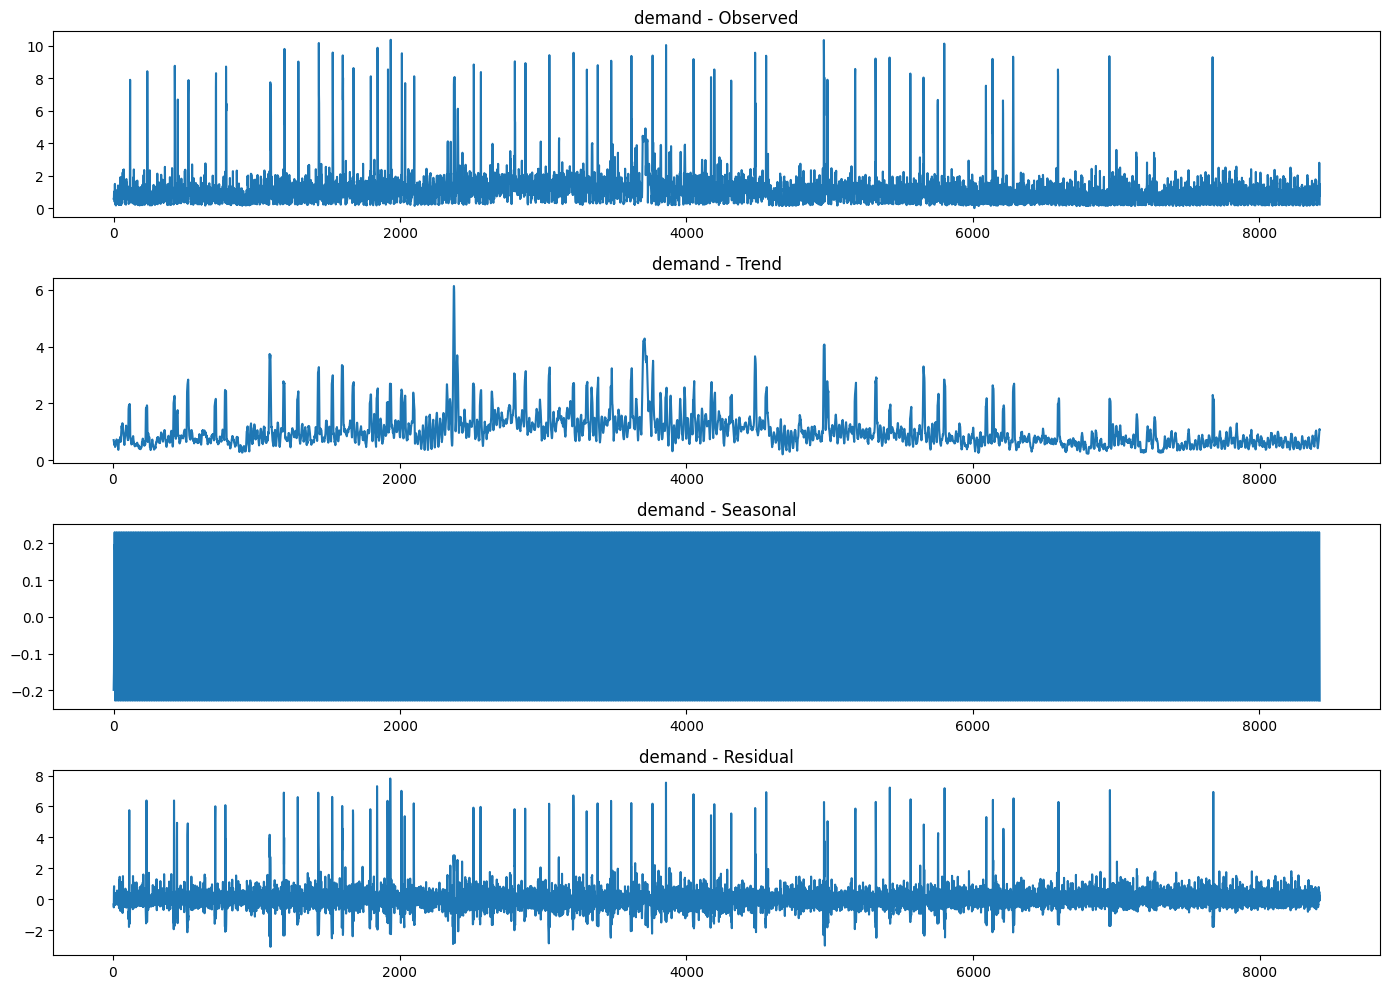

ADF Test Statistic: -11.370282832972501
p-value: 9.014578325605461e-21


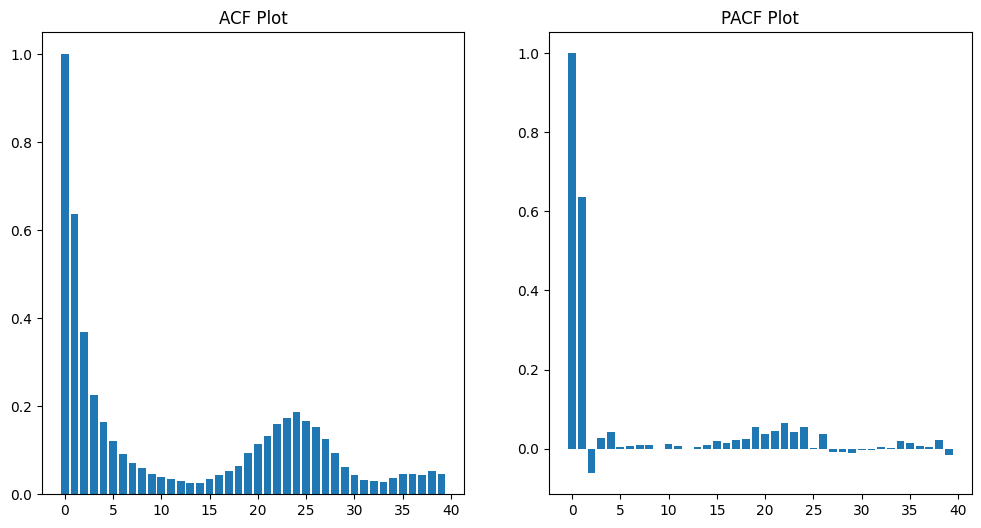

C:\Users\IvanSukhanov\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA Model MAE: 0.49964260900893004
SARIMAX Model MAE with temp, dwpt, and price: 0.49181349255279977

Model Comparison:
SARIMA MAE: 0.49964260900893004
SARIMAX MAE: 0.49181349255279977
SARIMAX performs better. Model incorporates external factors (temp, dwpt, price) affecting demand.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

file_path = r"C:\Users\IvanSukhanov\Desktop\PhD\Classes\Energy\HW2\train.csv"
data = pd.read_csv(file_path)

# Missing data
missing_data = data.isnull().sum()

# Missing values for 'snow'
data['snow'] = data['snow'].fillna(0)

# Missing values for 'demand'
data['demand'] = data['demand'].fillna(data['demand'].median())

# Statistical desc.
description = data.describe()

# Visualizations
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap")
plt.show()

# Distributions of variables
variables_to_analyze = [col for col in data.columns if col != 'demand' and data[col].dtype in ['float64', 'int64']]

for var in variables_to_analyze:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[var], kde=True, color='skyblue', bins=30)
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.show()

# Transformations/standardization
scaler = StandardScaler()
numerical_cols = [col for col in data.columns if data[col].dtype in ['float64', 'int64'] and col != 'demand']
data_scaled = data.copy()
data_scaled[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Plot 'temp', 'dwpt', and 'price' over time
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(data['temp'], label="temp (°C)", color='orange', alpha=0.8)
ax1.plot(data['dwpt'], label="dwpt (°C)", color='blue', alpha=0.8)
ax1.set_xlabel("time")
ax1.set_ylabel("temp / dwpt (°C)")
ax1.legend(loc="upper left")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(data['price'], label="price", color='green', alpha=0.8)
ax2.set_ylabel("price")
ax2.legend(loc="upper right")

plt.title("temp, dwpt, price")
plt.show()

# Seasonal and trend decomposition
for col in ['temp', 'dwpt', 'price', 'demand']:
    decomposition = seasonal_decompose(data[col], model='additive', period=12)

    plt.figure(figsize=(14, 10))
    plt.subplot(411)
    plt.plot(decomposition.observed, label="Observed")
    plt.title(f"{col} - Observed")
    plt.subplot(412)
    plt.plot(decomposition.trend, label="Trend")
    plt.title(f"{col} - Trend")
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label="Seasonal")
    plt.title(f"{col} - Seasonal")
    plt.subplot(414)
    plt.plot(decomposition.resid, label="Residual")
    plt.title(f"{col} - Residual")
    plt.tight_layout()
    plt.show()

# Stationarity, ACF/PACF for SARIMA
demand_series = data['demand']
adf_test = adfuller(demand_series)

print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

if adf_test[1] > 0.05:  # If not stationary
    demand_diff = demand_series.diff().dropna()
else:
    demand_diff = demand_series

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("ACF Plot")
plt.bar(range(len(acf(demand_diff))), acf(demand_diff))
plt.subplot(122)
plt.title("PACF Plot")
plt.bar(range(len(pacf(demand_diff))), pacf(demand_diff))
plt.show()

# SARIMA Model
sarima_model = ARIMA(demand_series, order=(1, 1, 1))
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.predict(start=1, end=len(demand_series), dynamic=False)
sarima_pred = sarima_pred[:len(demand_series) - 1]  # Align with actual data
mae_sarima = mean_absolute_error(demand_series[1:], sarima_pred)
print("SARIMA Model MAE:", mae_sarima)

# SARIMAX Model with exogenous features (temp, dwpt, price)
exogenous_features = data_scaled[['temp', 'dwpt', 'price']].reindex(demand_series.index)
sarimax_model = SARIMAX(demand_series, exog=exogenous_features, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = sarimax_model.fit()
sarimax_pred = sarimax_fit.predict(start=1, end=len(demand_series) - 1, exog=exogenous_features.iloc[1:])
mae_sarimax = mean_absolute_error(demand_series[1:], sarimax_pred)
print("SARIMAX Model MAE with temp, dwpt, and price:", mae_sarimax)

# MAE
print("\nModel Comparison:")
print(f"SARIMA MAE: {mae_sarima}")
print(f"SARIMAX MAE: {mae_sarimax}")
print("SARIMAX performs better. Model incorporates external factors (temp, dwpt, price) affecting demand.")